In [10]:
import sys
sys.path.insert(0, "../src")

from tqdm import tqdm

import torch
import torch.nn as nn
from fff import FFF
import matplotlib.pyplot as plt

In [11]:
batch_size = 128
entropy_effect = 0.10
n_epochs = 5

leaf_width = 16
depth = 3
activation = nn.ReLU()
leaf_dropout = 0.0

In [12]:
# Load the MNIST dataset
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset_training = datasets.MNIST('data', download=True, train=True, transform=transform)
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=batch_size, shuffle=True)
dataset_testing = datasets.MNIST('data', download=True, train=False, transform=transform)
dataloader_testing = torch.utils.data.DataLoader(dataset_testing, batch_size=batch_size, shuffle=True)

In [13]:
# setup the FFF model
model = FFF(input_width=784, hidden_width=leaf_width, output_width=10, depth=depth, activation=activation, dropout=leaf_dropout)

In [14]:
# train the model
training_losses = []
training_accuracies = []
training_entropies = []
epoch_testing_losses = []
epoch_testing_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(n_epochs):
	print("Epoch", epoch)

	model.train()
	for batch_images, batch_labels in tqdm(dataloader_training):
		optimizer.zero_grad()

		output, node_entropies = model(batch_images.view(-1, 784), return_entropies=True)
		node_entropy_mean = node_entropies.mean()
		loss = criterion(output, batch_labels) + entropy_effect * node_entropy_mean
		accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

		training_losses.append(loss.item())
		training_accuracies.append(accuracy.item())
		training_entropies.append(node_entropy_mean.item())

		loss.backward()
		optimizer.step()
	
	# test the model
	model.eval()
	testing_losses = []
	testing_accuracies = []
	for batch_images, batch_labels in tqdm(dataloader_testing):
		output = model(batch_images.view(-1, 784))
		loss = criterion(output, batch_labels)
		accuracy = (output.argmax(dim=1) == batch_labels).detach().float().mean()

		testing_losses.append(loss.item())
		testing_accuracies.append(accuracy.item())
	epoch_testing_losses.append(sum(testing_losses) / len(testing_losses))
	epoch_testing_accuracies.append(sum(testing_accuracies) / len(testing_accuracies))

Epoch 0


100%|██████████| 79/79 [00:02<00:00, 35.18it/s]


Epoch 1


100%|██████████| 79/79 [00:02<00:00, 32.39it/s]


Epoch 2


100%|██████████| 79/79 [00:02<00:00, 30.76it/s]


Epoch 3


100%|██████████| 79/79 [00:02<00:00, 35.07it/s]


Epoch 4


100%|██████████| 79/79 [00:02<00:00, 34.03it/s]


Text(0.5, 1.0, 'The evolution of training loss, accuracy, and mean node entropy')

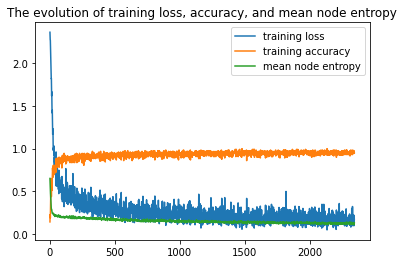

In [15]:
plt.plot(training_losses)
plt.plot(training_accuracies)
plt.plot(training_entropies)
plt.legend(["training loss", "training accuracy", "mean node entropy"], loc="upper right")
plt.title("The evolution of training loss, accuracy, and mean node entropy")

Text(0.5, 1.0, 'The evolution of testing loss and accuracy')

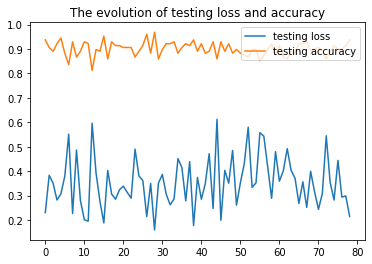

In [16]:
plt.plot(testing_losses)
plt.plot(testing_accuracies)
plt.legend(["testing loss", "testing accuracy"], loc="upper right")
plt.title("The evolution of testing loss and accuracy")